In [2]:
library(phyloseq)
library(ggplot2)
library(vegan)
library(readr)
library(data.table)
library(dplyr)
library(stats)
library(ggpubr)
#library(dunn.test)
library(viridis)

In [3]:
cmp_t = readRDS("/home/holutz/projects/CMP_redo/RDSfiles/cmp_t.rds")

In [7]:
#I used these functions to explore the data and see what my counts per host, anatomical site, etc looked like
cmp.df = data.frame(sample_data(cmp_t))
head(cmp.df$Host_taxon)
head(cmp.df$SystemType)
cmp.df %>% group_by(Host_taxon,SystemType) %>% summarize(count = n())

[1] Metasepia_pfefferi Euprymna_berryi    Euprymna_berryi    Sepia_bandensis   
[5] Euprymna_berryi    Euprymna_berryi   
9 Levels: Doryteuthis_pealeii Euprymna_berryi ... Wonderpus_photogenicus

[1] GI          Respiratory GI          GI          Light organ Respiratory
7 Levels: GI Light organ Negative Reproductive Respiratory ... Whole Animal

`summarise()` regrouping output by 'Host_taxon' (override with `.groups` argument)



Host_taxon,SystemType,count
<fct>,<fct>,<int>
Doryteuthis_pealeii,Whole Animal,4
Euprymna_berryi,GI,47
Euprymna_berryi,Light organ,5
Euprymna_berryi,Reproductive,16
Euprymna_berryi,Respiratory,14
Euprymna_berryi,Skin,13
Euprymna_scolopes,GI,2
Euprymna_scolopes,Reproductive,2
Euprymna_scolopes,Respiratory,1


In [8]:
GI_system = subset_samples(cmp_t, SystemType=="GI")
GI_Vibrio = subset_taxa(GI_system, Rank5=="f__Vibrionaceae")

In [9]:
#This function converts the phyloseq data into a data.frame so that we can plot relative abundances and whatnot
GI_Vibrio.mdf = psmelt(GI_Vibrio)

Warning message in psmelt(GI_Vibrio):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”


In [13]:
N = 10

topN = GI_Vibrio.mdf %>%
    group_by(Rank6) %>%
    summarize(Abundance = sum(Abundance)) %>%
    group_by(Rank6) %>%
    summarize(m = mean(Abundance)) %>%
    top_n(N) %>%
    arrange(desc(m)) %>%
    magrittr::extract2("Rank6")

mdfall.other = GI_Vibrio.mdf %>%
    mutate(Rank6.other = ifelse(Rank6 %in% topN, as.character(Rank6), "Other")) %>%
    group_by(Host_taxon, Sample, Rank6.other) %>%
    summarize(Abundance = sum(Abundance)) %>%
    arrange(Abundance)

mdfall.summary = mdfall.other %>%
    group_by(Host_taxon, Rank6.other) %>%
    summarise(avg = mean(Abundance), 
              sd = sd(Abundance), 
              sem = sd/sqrt(length(Abundance)),
              abundance = round(avg*100,2)) %>%
    arrange(Host_taxon)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

Selecting by m

`summarise()` regrouping output by 'Host_taxon', 'Sample' (override with `.groups` argument)

`summarise()` regrouping output by 'Host_taxon' (override with `.groups` argument)



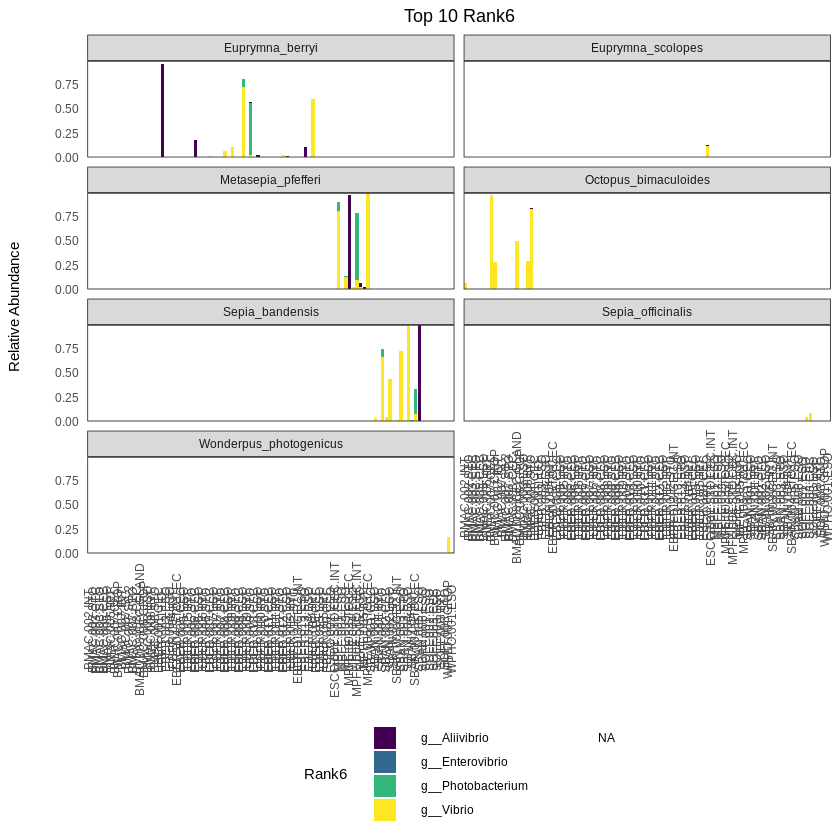

In [17]:
p = ggplot(mdfall.other[order(mdfall.other$Rank6.other),], aes(x=Sample, y = Abundance, fill = Rank6.other))
                        
p = p + #facet_wrap(~Host_taxon, shrink = TRUE, scales = "free_x") +
    ylab("Relative Abundance")  +
    geom_bar(stat="identity") +
    scale_fill_viridis(option="viridis", discrete=TRUE, direction=1) +
    scale_y_continuous(expand = c(0,0))

p = p + guides(fill = guide_legend(title = "Rank6", nrow = 4, keywidth = 1, keyheight = 1))

p = p + theme_bw() + theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=9, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              #axis.text.x = element_blank(),
              axis.ticks = element_blank(),
              axis.text.x=element_text(angle=90,vjust=0.4),
              #legend.key.size = unit(.25, "mm"),
              legend.spacing.x = unit(.2,"in"),
              axis.title.x=element_blank())

p = p + theme(legend.position="bottom") 

p = p + ggtitle("Top 10 Rank6") + theme(plot.title = element_text(hjust = 0.5))

p = p + facet_wrap(~Host_taxon, nrow = 4)

p

#png('/home/holutz/projects/CMP/temp.png', width=25, height=12, units='in', res=500)
#plot(p)
#dev.off()